In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive"

Mounted at /content/drive
MyDrive


# Importing libraries

In [3]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Conv1D, MaxPooling1D, GRU, Reshape, Flatten

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=ced72a7f4d5020a43dab9d86a6e1618050de40b01964f183a5b374757dc8e084
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Sample data set creation

In [9]:
%cd /content/drive/My Drive/Colab Notebooks/data
df_go = pd.read_csv('go_emotions.txt', names=['Text', 'Emotion'], sep=';')
df_w = pd.read_csv('df_w.csv', names=['Text', 'Emotion'], sep=';')

print("Shape of concatenated DataFrame:", df_w.shape)
print(df_w.shape)
emotion_counts = df_go['Emotion'].value_counts()
print("Emotion count for go", emotion_counts)
emotion_counts = df_w['Emotion'].value_counts()
print("Emotion count for full", emotion_counts)

# Extract data from two data sets and create balanced labelled dataset
# Filter rows with emotion "joy"
df_w_joy = df_w[df_w['Emotion'] == 'joy']
sampled_w_joy = df_w_joy.sample(n=3000, random_state=47)

# Filter rows with emotion "sadness"
df_w_sad = df_w[df_w['Emotion'] == 'sadness']
sampled_w_sad = df_w_sad.sample(n=2600, random_state=47)

# Filter rows with emotion "anger"
df_w_anger = df_w[df_w['Emotion'] == 'anger']
sampled_w_anger = df_w_anger.sample(n=2600, random_state=47)

# Filter rows with emotion "fear"
df_w_fear = df_w[df_w['Emotion'] == 'fear']
sampled_w_fear = df_w_fear.sample(n=2373, random_state=47)

# Filter rows with emotion "surprise"
df_w_surprise = df_go[df_go['Emotion'] == 'surprise']
sampled_w_surprise = df_w_surprise.sample(n=1781, random_state=47)

# Filter rows with emotion "disgust"
df_w_disgust = df_go[df_go['Emotion'] == 'disgust']
sampled_w_disgust = df_w_disgust.sample(n=2300, random_state=47)

# Filter rows with emotion "fear"
df_w_fear_g = df_go[df_go['Emotion'] == 'fear']
sampled_w_fear_g = df_w_fear_g.sample(n=200, random_state=47)

# Filter rows with emotion "sadness"
df_w_sad_g = df_go[df_go['Emotion'] == 'sadness']
sampled_w_sad_g = df_w_sad_g.sample(n=1250, random_state=47)

# Filter rows with emotion "love"
df_w_love = df_w[df_w['Emotion'] == 'love']
# Filter rows with emotion "surprise"
df_w_surprise = df_w[df_w['Emotion'] == 'surprise']

df_full = pd.concat([sampled_w_joy, sampled_w_sad, sampled_w_anger, sampled_w_fear, sampled_w_surprise, sampled_w_disgust, df_w_love, df_w_surprise, sampled_w_fear_g], ignore_index=True)

/content/drive/My Drive/Colab Notebooks/data
Shape of concatenated DataFrame: (20001, 2)
(20001, 2)
Emotion count for go Emotion
neutral     18423
anger        8084
joy          7983
sadness      6758
surprise     5514
disgust      5301
fear         3197
labels          1
Name: count, dtype: int64
Emotion count for full Emotion
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Emotion        1
Name: count, dtype: int64


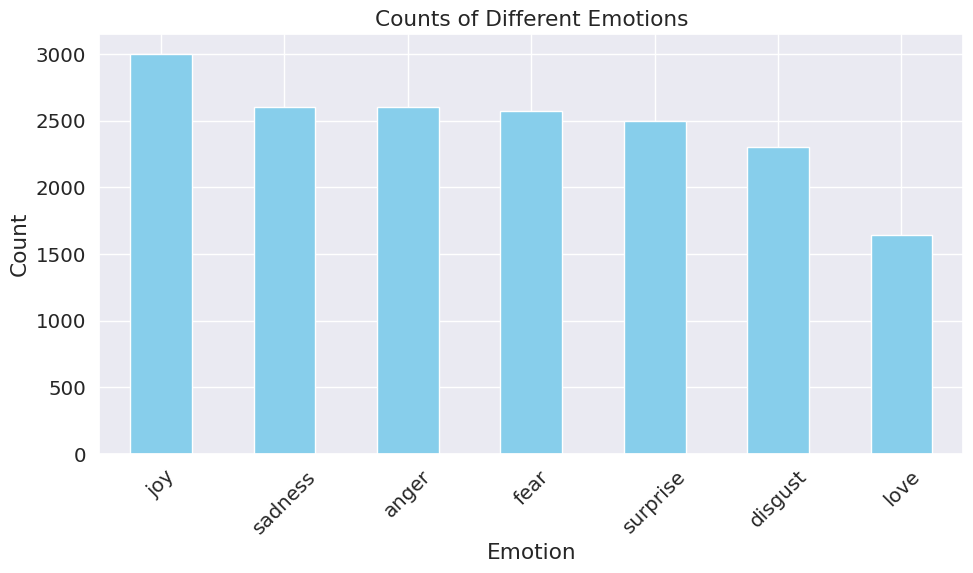

In [10]:
import matplotlib.pyplot as plt

# Assuming emotion_counts is a Pandas Series containing the counts of different emotions
# You can replace it with your actual emotion counts data
emotion_counts = df_full['Emotion'].value_counts()

# Plotting the counts of different emotions
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Different Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Cleaning and Preprocessing

In [94]:
#removing duplicated text
index = df_full[df_full['Text'].duplicated() == True].index
df_full.drop(index, axis = 0, inplace = True)
df_full.reset_index(inplace=True, drop = True)

emotion_counts = df_full['Emotion'].value_counts()
print("Emotion count for full", emotion_counts)
print("Shape", df_full.shape)
df_full.head()

Emotion count for full Emotion
joy         3000
sadness     2600
anger       2598
fear        2540
surprise    2296
disgust     1988
love        1631
Name: count, dtype: int64
Shape (16653, 2)


Text Emotion
0  i feel cute because the tune of the song days ...     joy
1  i like keeping a record of my life in written ...     joy
2                 im not feeling very graceful today     joy
3  i kinda get real attached and excited when i f...     joy
4  i leave feeling challenged and eager to study ...     joy

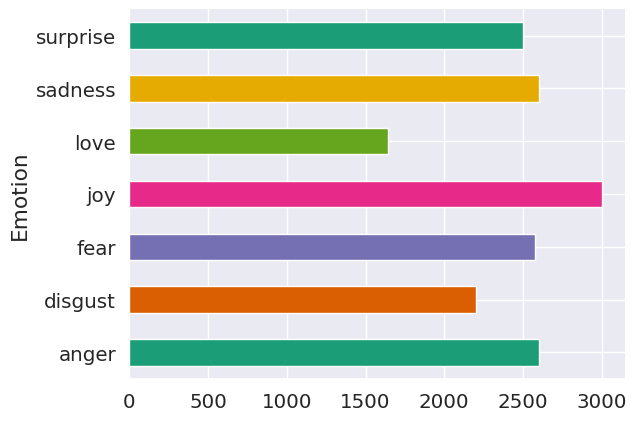

In [71]:
# @title Emotion

from matplotlib import pyplot as plt
import seaborn as sns
df_full.groupby('Emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [194]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

def normalize_sentences(sentences):
    normalized_sentences = []
    for sentence in sentences:
        normalize_sentence = normalized_sentence(sentence)
        normalized_sentences.append(normalize_sentence)
    return normalized_sentences



In [96]:
nltk.download("wordnet")
normalized_sentence("My Name is Udesh. @Tweets,  plays 2024")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'name udesh tweet play'

Dataset splitting

In [130]:
# Split the dataset into train, test, and validation sets
train_df, test_val_df = train_test_split(df_full, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

df_train = train_df
df_val = val_df
df_test = test_df

df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

## Tokenization, encoding and padding

In [132]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']
print(set(y_train))
print(set(y_test))
print(set(y_val))

{'love', 'joy', 'sadness', 'fear', 'anger', 'disgust', 'surprise'}
{'love', 'joy', 'sadness', 'fear', 'anger', 'disgust', 'surprise'}
{'love', 'joy', 'sadness', 'fear', 'anger', 'disgust', 'surprise'}


In [133]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
#print the labels after encoding
print(set(y_train))

{0, 1, 2, 3, 4, 5, 6}


In [134]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [135]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [136]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [137]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [138]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 13430


## Word Embedding

In [210]:
def load_glove_embeddings(path_to_glove_file, vocab_size, embedding_dim, tokenizer):
    """
    Load GloVe word embeddings and assign them to the vocabulary.

    Args:
    - path_to_glove_file (str): Path to the GloVe embeddings file.
    - vocab_size (int): Size of the vocabulary.
    - embedding_dim (int): Dimensionality of the word embeddings.
    - tokenizer (Tokenizer): Tokenizer object used to tokenize text data.

    Returns:
    - embedding_matrix (np.ndarray): Matrix containing word embeddings for the vocabulary.
    - hits (int): Number of words found in the GloVe embeddings.
    - misses (int): Number of words not found in the GloVe embeddings.
    """
    embeddings_index = {}
    hits = 0
    misses = 0

    # Read word vectors
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    # Assign word vectors to our dictionary/vocabulary
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix, hits, misses

# Example usage
path_to_glove_file = 'glove.twitter.27B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200

embedding_matrix, hits, misses = load_glove_embeddings(path_to_glove_file, num_tokens, embedding_dim, tokenizer)


Found 1193514 word vectors.
Converted 12425 words (1004 misses)


## Modeling

In [176]:
# Build neural network architecture

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Conv1D, Dense
from keras.optimizers import Adam

# Build neural network architecture
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))

model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(GRU(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 229, 200)          2686000   
                                                                 
 bidirectional_21 (Bidirect  (None, 229, 256)          336896    
 ional)                                                          
                                                                 
 conv1d_21 (Conv1D)          (None, 225, 256)          327936    
                                                                 
 gru_9 (GRU)                 (None, 128)               148224    
                                                                 
 dense_17 (Dense)            (None, 7)                 903       
                                                                 
Total params: 3499959 (13.35 MB)
Trainable params: 813959 (3.11 MB)
Non-trainable params: 2686000 (10.25 MB)
__________

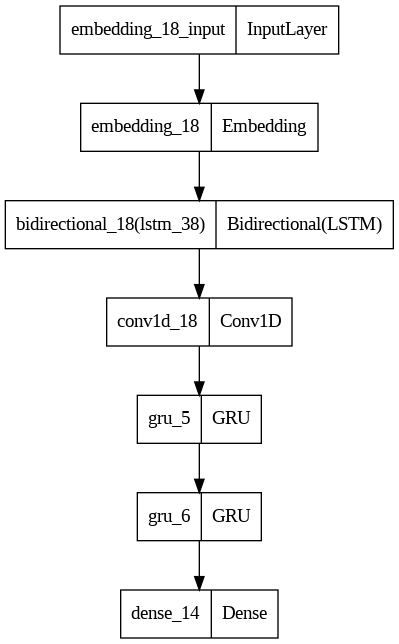

In [164]:

from keras.utils import plot_model
plot_model(model)

In [177]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

In [178]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=128,
                    epochs=20,
                    callbacks=[callback],
                    shuffle=True
                   )

Epoch 1/20
92/92 [==============================] - 168s 2s/step - loss: 1.2422 - accuracy: 0.5191 - val_loss: 0.7287 - val_accuracy: 0.7366
Epoch 2/20
92/92 [==============================] - 156s 2s/step - loss: 0.6304 - accuracy: 0.7701 - val_loss: 0.3868 - val_accuracy: 0.8667
Epoch 3/20
92/92 [==============================] - 156s 2s/step - loss: 0.4055 - accuracy: 0.8529 - val_loss: 0.3330 - val_accuracy: 0.8747
Epoch 4/20
92/92 [==============================] - 156s 2s/step - loss: 0.3282 - accuracy: 0.8775 - val_loss: 0.3123 - val_accuracy: 0.8839
Epoch 5/20
92/92 [==============================] - 156s 2s/step - loss: 0.2816 - accuracy: 0.8937 - val_loss: 0.3154 - val_accuracy: 0.8755
Epoch 6/20
92/92 [==============================] - 157s 2s/step - loss: 0.2603 - accuracy: 0.8996 - val_loss: 0.2902 - val_accuracy: 0.8891
Epoch 7/20
92/92 [==============================] - 156s 2s/step - loss: 0.2381 - accuracy: 0.9045 - val_loss: 0.3068 - val_accuracy: 0.8851
Epoch 8/20
92

In [179]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1)

79/79 [==============================] - 9s 114ms/step - loss: 0.2850 - accuracy: 0.8979


[0.2849634289741516, 0.8979183435440063]

In [180]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1)

79/79 [==============================] - 9s 114ms/step - loss: 0.2748 - accuracy: 0.8955


[0.27484312653541565, 0.8955163955688477]

In [181]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

79/79 [==============================] - 10s 115ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       406
           1       0.79      0.87      0.82       287
           2       0.88      0.86      0.87       398
           3       0.96      0.90      0.92       439
           4       0.87      0.95      0.91       240
           5       0.94      0.98      0.96       407
           6       0.86      0.74      0.80       321

    accuracy                           0.90      2498
   macro avg       0.89      0.89      0.89      2498
weighted avg       0.90      0.90      0.89      2498



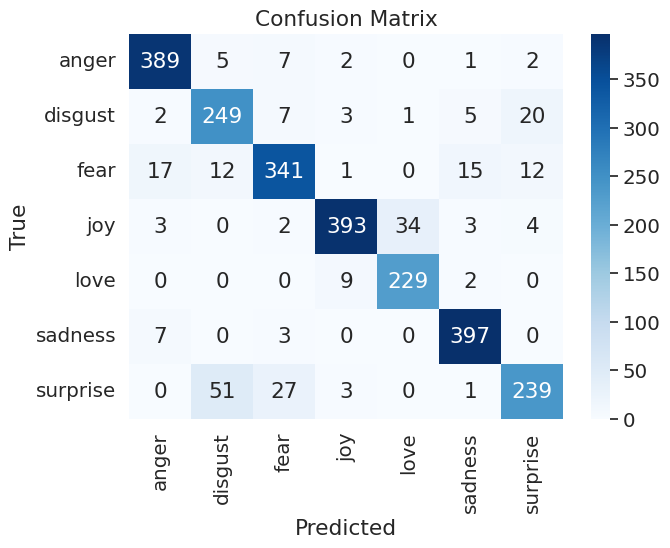

In [184]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert emotion labels to numerical labels
y_true = le.transform(df_test['Emotion'])

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

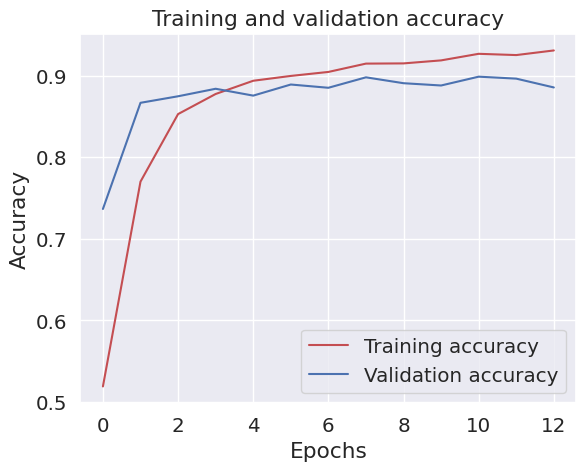

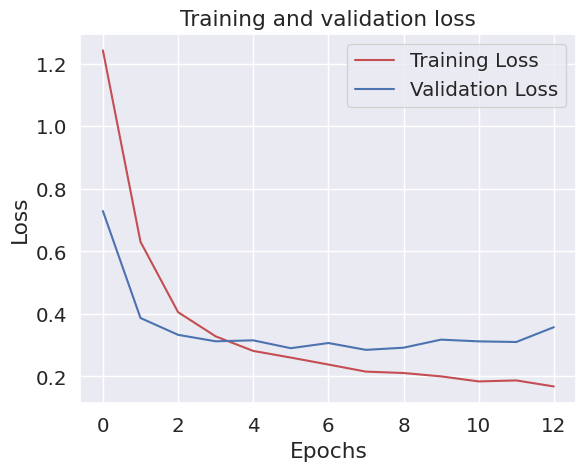

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')  # Add x axis label
plt.ylabel('Accuracy')  # Add y axis label
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')  # Add x axis label
plt.ylabel('Loss')  # Add y axis label
plt.legend()

plt.show()


In [209]:
# Classify custom sample

class_names = le.classes_

sentences = [
            "Running is a divine feeling for him",
            "I feel sorry for him",
            "I watched a horror movie",
            ]

for sentence in sentences:
    sentence1 = sentence
    print(sentence1)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")


from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

# Define a function to predict class probabilities
def predict_proba(sentences):
    sequences = normalize_sentences(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    sequences = pad_sequences(sequences, maxlen=229, truncating='pre')
    return model.predict(sequences)

# Use LIME to explain the predictions and visualize the explanations
explainer = LimeTextExplainer(class_names=class_names)
for sentence in sentences:
    sentence = str(sentence)  # Ensure sentence is a string
    print(sentence)

    # Explain prediction
    exp = explainer.explain_instance(sentence, predict_proba, num_features=10, top_labels=3)
    exp.show_in_notebook(text=True)
    plt.show()
    print("\n")

Running is a divine feeling for him
1/1 [==============================] - 0s 83ms/step
joy : 0.6105709671974182


I feel sorry for him
1/1 [==============================] - 0s 79ms/step
sadness : 0.9998089671134949


I watched a horror movie
1/1 [==============================] - 0s 80ms/step
fear : 0.982678234577179


Running is a divine feeling for him
157/157 [==============================] - 19s 123ms/step




I feel sorry for him
157/157 [==============================] - 19s 120ms/step




I watched a horror movie
157/157 [==============================] - 19s 122ms/step


In [199]:
sentence= 'I feel awesome today'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")
# Get the predicted labels and probabilities
predictions = model.predict(sentence)
sorted_indices = np.argsort(-predictions, axis=-1)
predicted_labels = le.inverse_transform(sorted_indices.reshape(-1))
predicted_probabilities = np.sort(predictions, axis=-1)[:, ::-1]
# Loop through each prediction
for i in range(len(predictions)):
    for j, index in enumerate(sorted_indices[i]):
        label = le.inverse_transform(index.reshape(-1))[0]
        probability = predicted_probabilities[i][j]
        print(f"{label} : {probability*100}%")
    print()

I feel awesome today
1/1 [==============================] - 0s 67ms/step
joy : 0.9680594801902771


1/1 [==============================] - 0s 75ms/step
joy : 96.80594801902771%
surprise : 3.1594548374414444%
love : 0.013006068184040487%
fear : 0.011579813144635409%
disgust : 0.006207544356584549%
sadness : 0.001986293682421092%
anger : 0.0018242228179587983%



In [197]:
# from joblib import dump

# # Save LabelEncoder to a file
# dump(le, 'label_encoder.joblib')
# dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

In [198]:
# model.save('BiLSTM-CNN-GRU.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
